In [2]:
%matplotlib inline

# TODO: clone from upstream https://git.savannah.gnu.org/cgit/bash.git

In [3]:
import re
import sqlite3
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('main.db')

project_name = 'bash'

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'
'''
raw_releases = con.execute(sql).fetchall()
# assert 0, raw_releases[:5] + raw_releases[-5:]

class Release:
    # @staticmethod
    # def strip(rawtag):
    #     if rawtag.startswith('bash-'):
    #         return rawtag.split('-')[1]
    #     return None

    @staticmethod
    def parse(tag):
        if tag.startswith('bash-'):
            tag = tag.split('-', 1)[1]
        rest = ''
        if '-' in tag:
            tag, rest = tag.split('-', 1)
            # assert rest=='', rest
        # rest = f'{rest=}'
        return tag, rest
        # return value.split('.') + [rest]

    @classmethod
    def is_interesting(cls, tag):
        return tag[-1] == ''

print(f'raw: {len(raw_releases)}')
print(raw_releases[:5] + raw_releases[-5:])
print()

names, dates=[], []
for rel_name,rel_date in raw_releases:
    # print(rel_name, Release.parse(rel_name))
    value, rest = Release.parse(rel_name)
    if rest:
        continue
    names.append(value)
    dates.append(rel_date)

print(names[:3], names[-3:])
# releases = list(rel for rel in raw_releases if Release.is_interesting(rel[0]))
# print(f'rel: {len(releases)}')
# print([row[0] for row in releases[:5] + releases[-5:]])
# print()

# names = [Release.strip(row[0]) for row in releases]
# dates = [row[1] for row in releases]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
print(dates[:3] + dates[-3:])

raw: 0
[]

[] []
[]


[]


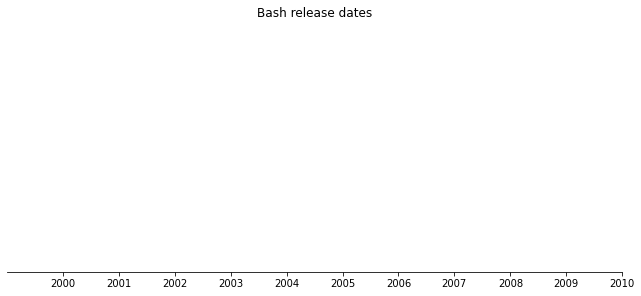

<Figure size 432x288 with 0 Axes>

In [4]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]
releases = list(zip(dates, levels, names))

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

# TODO: red lines on minor only
ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="black", markerfacecolor="white")  # Baseline and markers on it.

print(releases[:3])

def is_major(version):
        nums = Release.parse(version)
        if not nums:
                print(f'?? {version}')
                return False
        return len(nums) == 2 and nums[-1] == ['0']

def is_minor(version):
        return True
        # nums = Release.parse(version)
        # if not nums:
        #         print(f'?? {version}')
        #         return False
        # return len(nums) == 3 and nums[-1] == '0'

min_style = dict(textcoords="offset points",
                horizontalalignment="right")
major_style = dict(
        size=10, ha="center", va="center", # rotation=45, 
        bbox=dict(boxstyle="circle,pad=0.3", fc="cyan", ec="b", lw=2)
)

# annotate minor releases
for a_date, a_level, name in releases:
        if is_minor(name):
                label = name  # "major.minor"
        else:
                continue
        ax.annotate(label, xy=(a_date, a_level),
                xytext=(-3, np.sign(a_level)*3),
                verticalalignment="bottom" if a_level > 0 else "top",
                **min_style)

# major releases get big blue circle
for a_date, a_level, name in releases:
        if not is_major(name):
                continue
        label = name[:-4]  # "major" (no minor nor micro)
        ax.text(a_date, 0, label, **major_style)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set(title=f"{project_name.title()} release dates")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.2)

plt.show()

plt.savefig(f"{project_name}-releases.png")